# Homework 2

### Due: Sun Oct. 21 @ 9pm

In this homework we'll perform a hypothesis test and clean some data before training a regression model.


## Instructions

Follow the comments below and fill in the blanks (____) to complete.

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import seaborn as sns
import sklearn
import matplotlib.pylab as plt

# To suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

%matplotlib inline

## Part 1: Hypothesis Testing with an A/B test

Suppose we work at a large company that is developing online data science tools. Currently the tool has interface type A but we'd like to know if using interface tool B might be more efficient.
To measure this, we'll look at length of active work on a project (aka project length).
We'll perform an A/B test where half of the projects will use interface A and half will use interface B.

In [2]:
# read in project lengths from '../data/project_lengths'
# there should be 1000 observations for both interfaces
df_project = pd.read_csv('../data/project_lengths.csv')
df_project.info()
df_project.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
lengths_A    1000 non-null float64
lengths_B    1000 non-null float64
dtypes: float64(2)
memory usage: 15.7 KB


,lengths_A,lengths_B
0,5.191470,4.038233
1,3.265106,11.055010
2,50.170632,3.542817
3,3.411306,48.874282
4,39.300082,3.771299


In [3]:
# calculate the difference in mean project length between interface A and B
# for consistency, subtracting A from B
# hint: this number should be negative here (could interpret as faster)
mean_A = df_project["lengths_A"].mean()
mean_B = df_project["lengths_B"].mean()
observed_mean_diff = mean_B-mean_A
observed_mean_diff

-1.5819526645395978

In [4]:
# we'll perform a permutation test to see how significant this result is
# generate 10000 random permutation samples of mean difference
# hint: use np.random.permutation
rand_mean_diffs = []
n_samples = 10000
combined_times = np.concatenate([df_project.lengths_A.values, df_project.lengths_B.values])
n_A = 1000 # number of observations for page A
for i in range(n_samples):
    rand_perm = np.random.permutation(combined_times)
    rand_mean_A = rand_perm[:1000].mean()
    rand_mean_B = rand_perm[1000:].mean()
    rand_mean_diffs.append(rand_mean_B-rand_mean_A)

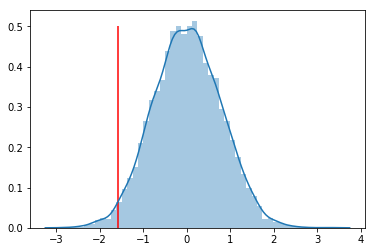

In [5]:
# use seaborn to plot the distribution of mean differences
# use plt.vlines to plot a line at our observed difference in means (ymin=0,ymax=0.5)
plot = sns.distplot(rand_mean_diffs,norm_hist=False, kde=True)
_ = plt.vlines(observed_mean_diff, 0, 0.5, colors='r')

In [6]:
# the plot should seem to indicate significance, but let's calculate a one-tailed p_value using rand_mean_diffs
p_value = sum(np.array(rand_mean_diffs) >= observed_mean_diff)/len(rand_mean_diffs)
p_value

0.9816

In [7]:
# we can calculate the effect size of our observation
# this is the absolute value of the observed_mean_diff divided by the standard deviation of the combined_times
observed_effect_size = abs(observed_mean_diff/np.std(combined_times))
observed_effect_size

0.0903782039609031

In [8]:
# we'll use this for the next 2 steps
from statsmodels.stats.power import tt_ind_solve_power

In [9]:
# what is the power of our current experiment?
# e.g. how likely is it that correctly decided that B is better than A 
#   given the observed effect size, number of observations and alpha level we used above
# since these are independent samples we can use tt_ind_solve_power
# hint: the power we get should not be good
power = tt_ind_solve_power(effect_size = observed_effect_size,  # what we just calculated
                           nobs1 = n_A,         # the number of observations in A
                           alpha = 0.05,        # our alpha level
                           power = None,        # what we're interested in
                           ratio = 1            # the ratio of number of observations of A and B
                          )
power

0.5239497439166989

In [10]:
# how many observations for each of A and B would we need to get a power of .9
#   for our observed effect size and alpha level
# eg. having a 90% change of correctly deciding B is better than A
n_obs_A = tt_ind_solve_power(effect_size = observed_effect_size,  # what we just calculated
                           nobs1 = None,         # the number of observations in A
                           alpha = 0.05,        # our alpha level
                           power = 0.9,        # what we're interested in
                           ratio = 1            # the ratio of number of observations of A and B
                          )
n_obs_A

2573.7171120419607

## Part 2: Data Cleaning and Regression

### Data Preparation and Exploration

This data is provided by World Bank Open Data https://data.worldbank.org/, processed as in Homework 1.

We will be performing regression with respect to GDP and classification with respect to Income Group.
To do that we will first need to do a little more data prep.

In [11]:
# read in the data
df_country = pd.read_csv('../data/country_electricity_by_region.csv')

# rename columns for ease of reference
columns = ['country_code','short_name','region','income_group','access_to_electricity','gdp','population_density',
           'population_total','unemployment','region_europe','region_latin_america_and_caribbean',
           'region_middle_east_and_north_africa','region_north_america','region_south_asia',
           'region_subsaharan_africa']

df_country.columns = columns
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 15 columns):
country_code                           217 non-null object
short_name                             217 non-null object
region                                 217 non-null object
income_group                           217 non-null object
access_to_electricity                  217 non-null float64
gdp                                    193 non-null float64
population_density                     215 non-null float64
population_total                       216 non-null float64
unemployment                           113 non-null float64
region_europe                          217 non-null int64
region_latin_america_and_caribbean     217 non-null int64
region_middle_east_and_north_africa    217 non-null int64
region_north_america                   217 non-null int64
region_south_asia                      217 non-null int64
region_subsaharan_africa               217 non-null int64
dtypes: flo

In [12]:
# create a dummy variable 'gdp_missing' to indicate where 'gdp' is null
df_country['gdp_missing'] = df_country['gdp'].isnull()

In [13]:
# use groupby to find the number of missing gpd by income_level
# write a lambda function to apply to the grouped data, counting the number of nulls per group
#df_country.groupby('income_group').apply(lambda x: x['gdp_missing'].sum()).reset_index(name='count')
df_country.groupby('income_group').gdp.apply(lambda x: x.isnull().sum())

income_group
High income            18
Low income              3
Lower middle income     1
Upper middle income     2
Name: gdp, dtype: int64

In [14]:
# fill in missing gdp values according to income_group mean
# to do this, group by income_group 
# then apply a lambda function to the gdp column that uses the fillna function, filling with the mean
# inplace is not available here, so assign back into the gdp column
df_country.gdp = df_country.groupby('income_group').gdp.apply(lambda x: x.fillna(x.mean()))
df_country['gdp_missing'] = df_country['gdp'].isnull()

In [15]:
# assert that there are no longer any missing values in gdp
assert sum(df_country['gdp_missing']) == 0

In [16]:
# create 'populiation_density_missing' dummy variable
df_country['population_density_missing'] = df_country['population_density'].isnull()

In [17]:
# fill in missing population_density with median, grouping by region
df_country.population_density = df_country.groupby('region').population_density.apply(lambda x: x.fillna(x.median()))

In [18]:
# create a normalized 'gdp_zscore' column
from scipy.stats import zscore
df_country['gdp_zscore'] = zscore(df_country['gdp'])

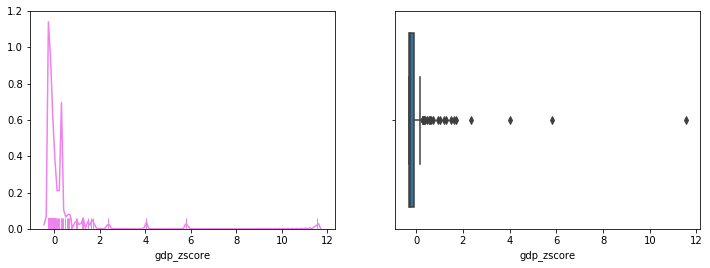

In [19]:
# use seaborn to create a distplot (with rugplot indicators) and a boxplot of gdp_zscores to visualize outliers
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.distplot(df_country['gdp_zscore'],hist=False,kde=True,ax=ax[0],rug=True,color="violet")
sns.boxplot(df_country['gdp_zscore'],ax=ax[1])

In [20]:
# print the top 10 country_code and gdp_zscore sorted by gdp_zscore
df_country.sort_values(by=['gdp_zscore'],ascending=False)[['country_code','gdp_zscore']].head(n=10)

,country_code,gdp_zscore
203,USA,11.552402
36,CHN,5.807531
98,JPN,4.035723
50,DEU,2.365951
64,FRA,1.717156
68,GBR,1.626685
26,BRA,1.479186
89,IND,1.264916
95,ITA,1.201040
32,CAN,1.007785


In [21]:
# set a zscore cutoff to remove the top 4 outliers
gdp_zscore_cutoff = 2.36

In [22]:
# create a normalized 'population_density_zscore' column
df_country['population_density_zscore'] = zscore(df_country['population_density'])

In [23]:
# print the top 10 country_code and population_density_zscore sorted by population_density_zscore
df_country.sort_values(by=['population_density_zscore'],ascending=False)[['country_code','population_density_zscore']].head(n=10)

,country_code,population_density_zscore
118,MAC,9.660487
121,MCO,9.474560
170,SGP,3.703655
82,HKG,3.287870
71,GIB,1.512029
19,BHR,0.662775
124,MDV,0.461115
129,MLT,0.460529
24,BMU,0.443888
17,BGD,0.404138


In [24]:
# set a zscore cutoff to remove the top 5 outliers
population_density_zscore_cutoff = 1.51

In [25]:
# drop outliers (considering both gdp_zscore and population_density_zscore)
df_country = df_country[(df_country.population_density_zscore < population_density_zscore_cutoff) & (df_country.gdp_zscore < gdp_zscore_cutoff)]
df_country.shape

(208, 19)

### Train a Regression Model

In [26]:
# create the training set of X with features (population_density, access_to_electricity) 
# and labels y (gdp)
X = df_country[['population_density','access_to_electricity']]
y = df_country['gdp']

In [27]:
# import and initialize a LinearRegression model using default parameters
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [28]:
# train the regressor on X and y
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
# print out the learned intercept and coefficients
print(lr.intercept_)
print(lr.coef_[0])
print(lr.coef_[1])

-124778701696.41547
93890100.76729567
4352251616.858018


In [30]:
# we can use this mask to easily index into our dataset
country_mask = (df_country.country_code == 'CAN').values

In [31]:
# how far off is our model's prediction for Canada's gdp (country_code CAN) from it's actual gdp?
abs(lr.predict(df_country[country_mask][['population_density','access_to_electricity']])-df_country[country_mask].gdp)

32    1.468798e+12
Name: gdp, dtype: float64

In [32]:
# create a new training set X that, in addition to population_density and access_to_electricity,
# also includes the region_* dummies
X = df_country[['population_density','access_to_electricity','region_europe','region_latin_america_and_caribbean',
           'region_middle_east_and_north_africa','region_north_america','region_south_asia',
           'region_subsaharan_africa']].values

In [33]:
# instantiate a new model and train, with fit_intercept=False
lr = LinearRegression(fit_intercept=False)

In [34]:
# did the prediction for CAN improve?
lr.fit(X,y)

abs(lr.predict(df_country[country_mask][['population_density','access_to_electricity','region_europe','region_latin_america_and_caribbean',
           'region_middle_east_and_north_africa','region_north_america','region_south_asia',
           'region_subsaharan_africa']])-df_country[country_mask].gdp)

# Accuracy has improved hugely and hence this is more efficient in predicting

32    5.300059e+11
Name: gdp, dtype: float64